##What are Convolutions? Что такое свертки?

В следующей лабораторной работе вы узнаете, как улучшить свой пример компьютерного зрения с помощью сверток. Но что такое свертки? В этой лабораторной работе вы изучите, что это такое и как они работают, а затем в лабораторной работе 4 вы увидите, как использовать их в своей нейронной сети.

Вместе со свертками вы будете использовать так называемое «Pooling», которое сжимает ваше изображение, еще больше подчеркивая его особенности. В этой лабораторной работе вы также увидите, как работает объединение.

##Ограничения предыдущего DNN
В последней лабораторной работе вы узнали, как обучить классификатор изображений одежды и обуви с использованием набора данных Fashion MNIST. Это дало вам довольно точный классификатор, но существовало очевидное ограничение: изображения имели размер 28x28, оттенки серого, а элемент располагался по центру изображения.

Например, вот пара изображений в Fashion MNIST.
![Изображение свитера и ботинок](https://cdn-images-1.medium.com/max/1600/1*FekMt6abfFFAFzhQcnjxZg.png)

Созданная вами DNN просто узнала из необработанных пикселей, из чего состоит свитер, а из чего — ботинки в данном контексте. Но подумайте, как можно классифицировать это изображение?

![образ ботинок](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTD93hoMmqQHMMYPODzaB8z3MELeg1BWxbjVq8VsnAcOA&s=)

Хотя очевидно, что на этом изображении есть ботинки, классификатор не сработает по ряду причин. Во-первых, конечно, это не оттенки серого 28x28, но, что более важно, классификатор обучался на необработанных пикселях левого ботинка, а не на функциях, которые определяют, что такое ботинок.

Вот где свертки очень сильны. Свертка — это фильтр, который пропускает изображение, обрабатывает его и извлекает признаки, показывающие общие черты изображения. В этой лабораторной работе вы увидите, как они работают, а также обработаете изображение, чтобы узнать, сможете ли вы извлечь из него признаки!




Генерировать свертки очень просто — вы просто сканируете каждый пиксель изображения, а затем смотрите на соседние с ним пиксели. Вы умножаете значения этих пикселей на эквивалентные веса в фильтре.

Итак, например, рассмотрим следующее:

![Свертка на изображении](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig1.png)

В этом случае указывается свертка 3x3.

Текущее значение пикселя — 192, но вы можете вычислить новое, просмотрев значения соседей и умножив их на значения, указанные в фильтре, и приняв новое значение пикселя как сумму произведений значений пикселей на их коэффициенты.


Давайте рассмотрим, как работают свертки, создав базовую свертку на `2D Grey Scale` изображения. Сначала мы можем загрузить изображение, взяв изображение 'ascent' из `scipy`. Это красивое встроенное изображение с множеством углов и линий.

Начнем с импорта некоторых библиотек Python.

In [13]:
import cv2
import numpy as np
from scipy.datasets import ascent
img = ascent()

Далее мы можем использовать библиотеку `pyplot`, чтобы нарисовать изображение и узнать, как оно выглядит.

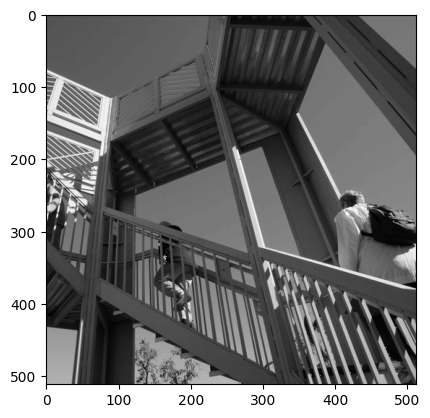

In [24]:
import matplotlib.pyplot as plt
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(img)
plt.show()

Мы видим, что это изображение лестничной клетки. Здесь есть множество функций, с которыми мы можем поиграть, чтобы посмотреть, сможем ли мы их изолировать — например, есть сильные вертикальные линии.

Изображение хранится в виде массива numpy, поэтому мы можем создать преобразованное изображение, просто скопировав этот массив. Давайте также получим размеры изображения, чтобы мы могли просмотреть его позже.

In [20]:
i_transformed = np.copy(img)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

Теперь мы можем создать фильтр в виде массива 3x3.

In [28]:
# Этот фильтр хорошо обнаруживает края
# Он создает извилину, которая проходит только через острые края и прямые
# строки.

#Поэкспериментируйте с разными значениями для получения забавных эффектов.
# filter = [ [0, 1, 0], [1, -4, 1], [0, 1, 0]]

# Еще пара фильтров, которые стоит попробовать ради развлечения!
# filter = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1]]
filter = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

# Если в сумме все цифры в фильтре не равны 0 или 1, то вам следует изменить вес,
# чтобы получить сумму равную 0 или 1, например, если ваши коэффициенты [[1,1,1],[1,2,1],[1,1,1]]
# в сумме они дают 10, поэтому вам следует установить weight=0,1, если вы хотите их нормализовать
weight  = 1

Теперь давайте создадим свертку. Мы будем перебирать изображение, оставляя запас в 1 пиксель, и умножать каждого из соседей текущего пикселя на значение, определенное в фильтре.
Т.е. сосед текущего пикселя над ним и слева будет умножен на верхний левый элемент фильтра и т.д. и т.п. Затем мы умножим результат на вес, а затем убедимся, что результат находится в диапазоне 0–255.

Наконец, мы загрузим новое значение в преобразованное изображение.

In [29]:
for x in range(1,size_x-1):
  for y in range(1,size_y-1):
      convolution = 0.0
      convolution = convolution + (img[x - 1, y-1] * filter[0][0])
      convolution = convolution + (img[x, y-1]     * filter[0][1])
      convolution = convolution + (img[x + 1, y-1] * filter[0][2])
      convolution = convolution + (img[x-1, y]     * filter[1][0])
      convolution = convolution + (img[x, y]       * filter[1][1])
      convolution = convolution + (img[x+1, y]     * filter[1][2])
      convolution = convolution + (img[x-1, y+1]   * filter[2][0])
      convolution = convolution + (img[x, y+1]     * filter[2][1])
      convolution = convolution + (img[x+1, y+1]   * filter[2][2])
      convolution = convolution * weight
      if(convolution<0):
        convolution=0
      if(convolution>255):
        convolution=255
      i_transformed[x, y] = convolution

Теперь мы можем построить изображение, чтобы увидеть эффект свертки!

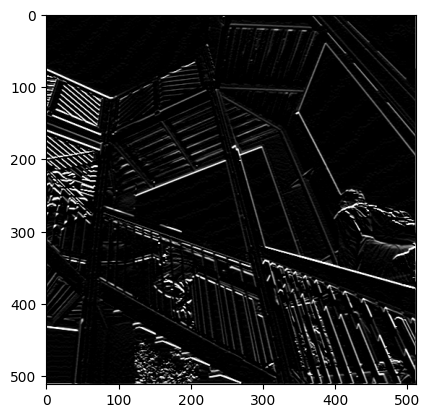

In [30]:
# Постройте изображение. Обратите внимание на размер осей — они 512 на 512.
plt.gray()
plt.grid(False)
plt.imshow(i_transformed)
#plt.axis('off')
plt.show()

Итак, рассмотрим следующие значения фильтра и их влияние на изображение.

Использование -1,0,1,-2,0,2,-1,0,1 дает нам очень сильный набор вертикальных линий:

![Detecting vertical lines filter](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig2.png)

Использование -1, -2, -1, 0, 0, 0, 1, 2, 1 дает нам горизонтальные линии:

![Detecting horizontal lines](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig3.png)

Изучите отличия!

## Pooling

Помимо использования сверток, объединение в пул очень помогает нам в обнаружении функций. Цель состоит в том, чтобы уменьшить общий объем информации в изображении, сохраняя при этом обнаруженные признаки.

Существует несколько различных типов объединения, но в этой лабораторной работе мы будем использовать тот, который называется `MAX pooling`.

 Идея здесь состоит в том, чтобы перебрать изображение и посмотреть на rf;lsq пиксель и его ближайших соседей справа, снизу и справа под ним. Взять самый большой из них (отсюда и название `MAX pooling`) и звзять его в новое озображение. Таким образом, размер нового изображения будет составлять 1/4 размера старого, а размеры по X и Y в результате этого процесса уменьшатся вдвое. Вы увидите, что признаки сохраняются, несмотря на это сжатие!

![Max Pooling](https://storage.googleapis.com/learning-datasets/MLColabImages/lab3-fig4.png)

Этот код покажет `pooling` (2, 2). Запустите его, чтобы увидеть результат, и вы увидите, что, хотя размер изображения составляет 1/4 размера оригинала, отличительные признаки сохраняются!



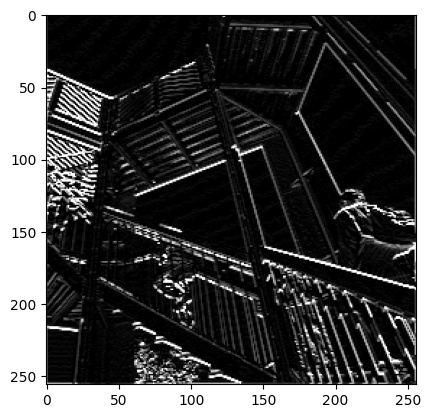

In [31]:
new_x = int(size_x/2)
new_y = int(size_y/2)
newImage = np.zeros((new_x, new_y))
for x in range(0, size_x, 2):
  for y in range(0, size_y, 2):
    pixels = []
    pixels.append(i_transformed[x, y])
    pixels.append(i_transformed[x+1, y])
    pixels.append(i_transformed[x, y+1])
    pixels.append(i_transformed[x+1, y+1])
    pixels.sort(reverse=True)
    newImage[int(x/2),int(y/2)] = pixels[0]

# Постройте изображение. Обратите внимание на размер осей — теперь 256 пикселей вместо 512.
plt.gray()
plt.grid(False)
plt.imshow(newImage)
#plt.axis('off')
plt.show()




В следующей лабораторной работе вы увидите, как добавить свертки в нейронную сеть Fashion MNIST, чтобы сделать ее более эффективной, поскольку она будет классифицировать на основе функций, а не необработанных пикселей.